<a href="https://colab.research.google.com/github/matteolimoncini/COVID-19-search-engine/blob/main/COVID_19_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install split-folders
!pip install clustimage

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import os
import urllib.request
import IPython.display as display
import shutil
from PIL import Image 
from random import randint

from clustimage import Clustimage

from keras.models import Model
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

import pickle

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
kaggle_path = '.kaggle'
if not (os.path.exists(kaggle_path)):
  !mkdir ~/.kaggle
  !echo '{"username":"matteolimoncini","key":"c4df437bb6e9108ad29ae9744b503c89"}' > ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json

#sarscov2 ctscan dataset

In [4]:
%%capture
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip sarscov2-ctscan-dataset.zip -d sarscov2-ctscan-dataset
!rm sarscov2-ctscan-dataset.zip

## Classification


check images size

In [5]:
folder_images = "./sarscov2-ctscan-dataset"
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}

sizes = []
for keys,values in size_images.items():
  sizes.append((values.get('width'),values.get('heigth')))


max_width = max(sizes,key=lambda item:item[0])[0]
min_width = min(sizes,key=lambda item:item[0])[0]
max_heigth = (max(sizes,key=lambda item:item[1])[1])
min_heigth = (min(sizes,key=lambda item:item[1])[1])
print ('max width images: '+str(max_width)+'\n'+'min width images: '+str(min_width))
print ('max heigth images: '+str(max_heigth)+'\n'+'min heigth images: '+str(min_heigth))

max width images: 534
min width images: 182
max heigth images: 416
min heigth images: 119


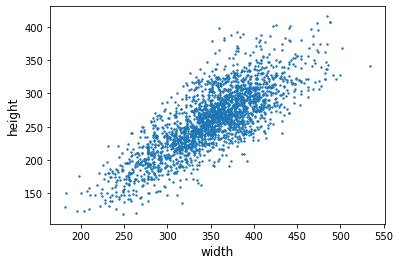

In [6]:
x = [i[0] for i in sizes]
y = [i[1] for i in sizes]
plt.scatter(x, y, s=2)
plt.xlabel('width', fontsize='large')
plt.ylabel('height', fontsize = 'large')
plt.show()

Is the dataset balanced?

In [7]:
covid = len(os.listdir('./sarscov2-ctscan-dataset/COVID'))
no_covid = len(os.listdir('./sarscov2-ctscan-dataset/non-COVID'))

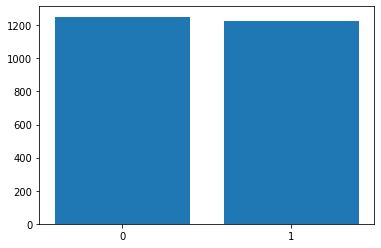

In [8]:
plt.bar([0,1], [covid, no_covid])
plt.xticks(np.arange(0, 2, 1))
plt.show()

In [9]:
TRAINING_DIR = '/content/splitted_img/train'
VALIDATION_DIR = '/content/splitted_img/val'
TEST_DIR = '/content/splitted_img/test'
IMG_SIZE = 256
BATCH_SIZE = 64
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
RANDOM_SEED = 10

split dataset in a random way. 80% training, 10% test, 10% validation

In [10]:
splitfolders.ratio("./sarscov2-ctscan-dataset", output="splitted_img", seed=RANDOM_SEED, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 2481 files [00:01, 1360.95 files/s]


In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale', 
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(VALIDATION_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                                      labels='inferred', label_mode='binary', color_mode = 'grayscale',
                                                                      image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
                                                                      seed = SEED,
                                                                      smart_resize = True)

Found 1984 files belonging to 2 classes.
Found 247 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


normalize pixel values from 0 to 1 instead of 0-255

In [12]:
def normalize_data(ds, shuffle = False):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))
    normalized_ds = normalized_ds.cache()

    if shuffle:
      normalized_ds = normalized_ds.shuffle(2000, seed=RANDOM_SEED)
    
    normalized_ds = normalized_ds.prefetch(buffer_size=AUTOTUNE)
    return normalized_ds
  
train_ds = normalize_data(train_dataset, True)
val_ds = normalize_data(val_dataset, False)
test_ds = normalize_data(test_dataset)

## Classification using a convolutional neural network

In [13]:
def first_cnn():
  model_cnn = tf.keras.models.Sequential([
                                          tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1), padding='same'),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
                                          tf.keras.layers.MaxPooling2D(2,2),
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(128, activation='relu'),
                                          tf.keras.layers.Dense(1, activation='sigmoid')
  ]
  )
  model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_cnn

In [14]:
first_try_cnn = first_cnn()

In [15]:
first_try_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4

In [16]:
EPOCHS=8

In [17]:
#@markdown Code to display dynamically loss and accuracy curve

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(14,9))

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = len(train_dataset)

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend(prop={'size':14})
    self.axes[1].legend(prop={'size':14})
    self.axes[0].set_xlabel('epochs',fontsize=14)
    self.axes[1].set_xlabel('epochs',fontsize=14)
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [18]:
plot_training = PlotTraining(sample_rate=10, zoom=1)

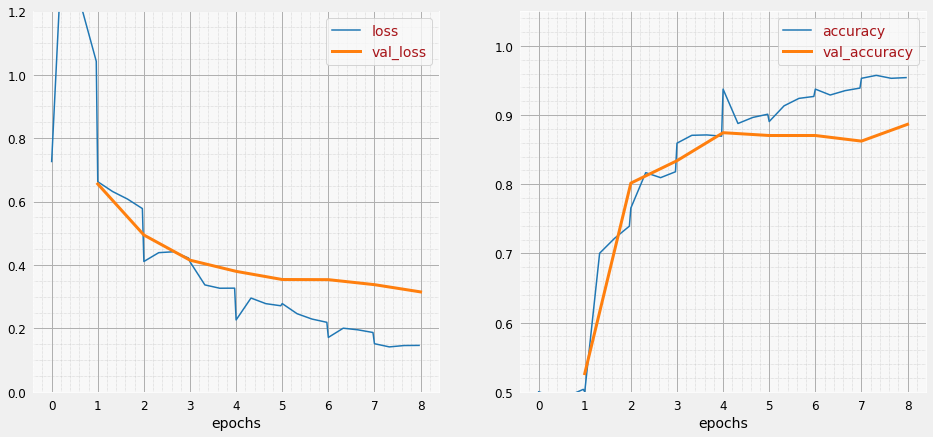

31/31 [==============================] - 54s 2s/step - loss: 0.1464 - accuracy: 0.9541 - val_loss: 0.3150 - val_accuracy: 0.8866


In [19]:
history = first_try_cnn.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS, verbose = 1,
  callbacks=[plot_training]
)
!mkdir -p saved_model
first_try_cnn.save('saved_model/my_model_firstry')

## Clustering

The idea is to use a cluster algorithm to divide in two clusters: images with covid sympthoms and images without covid sympthoms.
In this case we use only images without label, unsupervised learning.


In [20]:
path_images = r'/content/sarscov2-ctscan-dataset'

### Clustering with hog method

In [21]:
# Initialize
cl = Clustimage(method = 'hog', params_hog={'orientations':8, 'pixels_per_cell':(4,4), 'cells_per_block':(1,1)})

# Load dataset
pathnames = cl.import_data(path_images)

[clustimage] >WARNING> Parameter grayscale is set to True coz you are using method="hog"
[clustimage] >INFO> Extracting images from: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] files are collected recursively from path: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:13<00:00, 179.91it/s]


In [22]:
# Preprocessing of the first image
# color scale 0:cv2.IMREAD_GRAYSCALE 1:cv2.IMREAD_COLOR 
img = cl.imread(pathnames['pathnames'][0], dim=(128,128), colorscale=1, flatten=True)
# Extract HOG features
img_hog = cl.extract_hog(img, pixels_per_cell=(4,4), orientations=8, flatten=False)

100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


In [23]:
%%capture

list_hog =[]
for image in pathnames['pathnames']:
  img = cl.imread(image, dim=(128,128), colorscale=1, flatten=True)
  img_hog = cl.extract_hog(img, pixels_per_cell=(4,4), orientations=8, flatten=False)
  list_hog.append(img_hog)

Text(0.5, 1.0, 'HOG')

<Figure size 1008x648 with 0 Axes>

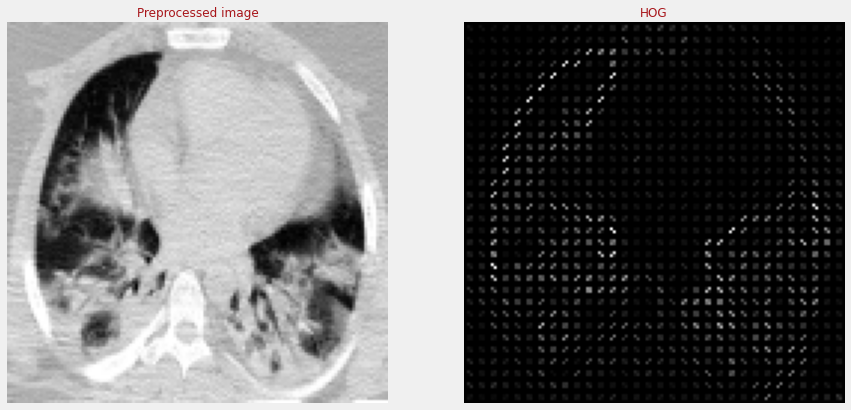

In [24]:
plt.figure();
fig,axs=plt.subplots(1,2, figsize=(15,10))
axs[0].imshow(img.reshape(128,128,3))
axs[0].axis('off')
axs[0].set_title('Preprocessed image', fontsize=12)
axs[1].imshow(img_hog, cmap='gray')
axs[1].axis('off')
axs[1].set_title('HOG', fontsize=12)

In [25]:
len(list_hog)

2481

In [26]:
results = cl.fit_transform(pathnames['pathnames'],
                           cluster='agglomerative',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=4,
                           cluster_space='high')

[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:14<00:00, 171.99it/s]
[clustimage] >INFO> Extracting features using method: [hog]
100%|██████████| 2481/2481 [06:56<00:00,  5.95it/s]
[clustimage] >INFO> Extracted features using [hog]: samples=2481, features=16384
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 2/2 [00:07<00:00,  3.62s/it]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (2481, 16384) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


### clustering with pca without fixing a number of clusters


In [27]:
# init with PCA method
# cl = Clustimage(method='pca')
cl = Clustimage(method='pca',
                embedding='tsne',
                grayscale=False,
                dim=(128,128),
                params_pca={'n_components':0.95})

# Load data
X = cl.import_data(path_images,flatten=True)

X = X['pathnames']

print(X)

# Preprocessing, feature extraction, embedding and cluster evaluation
results = cl.fit_transform(X,
                           cluster='agglomerative',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=5,
                          cluster_space='high')
results.keys()

[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> Extracting images from: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] files are collected recursively from path: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:18<00:00, 131.48it/s]
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.


['/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (316).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (99).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (760).png' ...
 '/content/sarscov2-ctscan-dataset/COVID/Covid (757).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (1124).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (249).png']


100%|██████████| 2481/2481 [00:18<00:00, 131.37it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [578] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=2481, features=578
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [pca] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████| 3/3 [00:00<00:00,  3.58it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (2481, 578) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [2].
[clusteval] >Fin.


dict_keys(['img', 'feat', 'xycoord', 'pathnames', 'labels', 'url', 'filenames'])

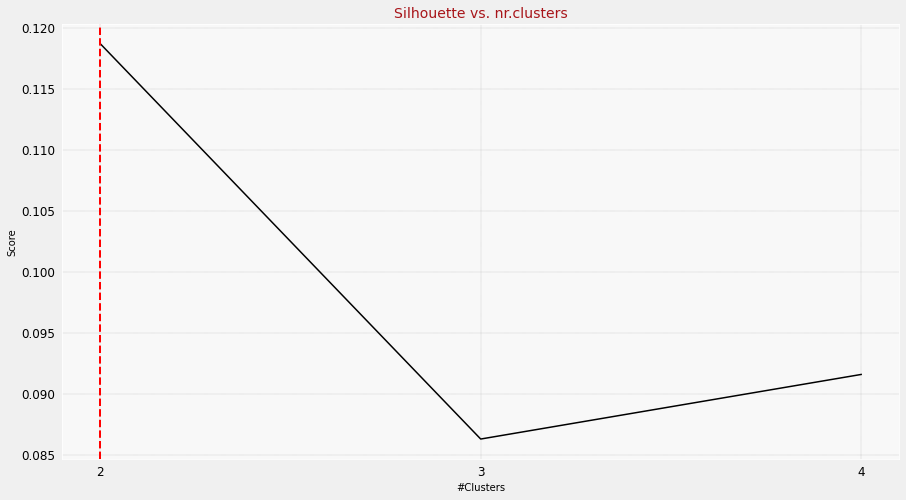

[clusteval] >Estimated number of n_clusters: 2, average silhouette_score=0.278


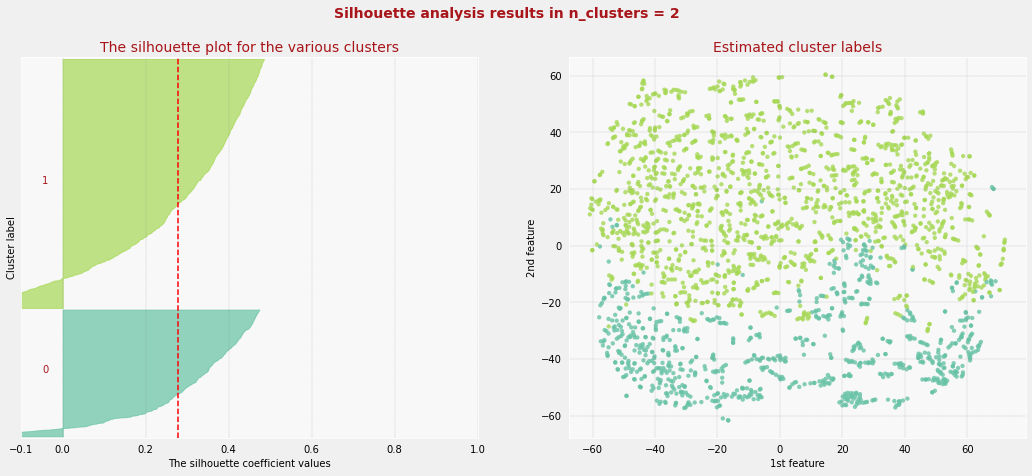

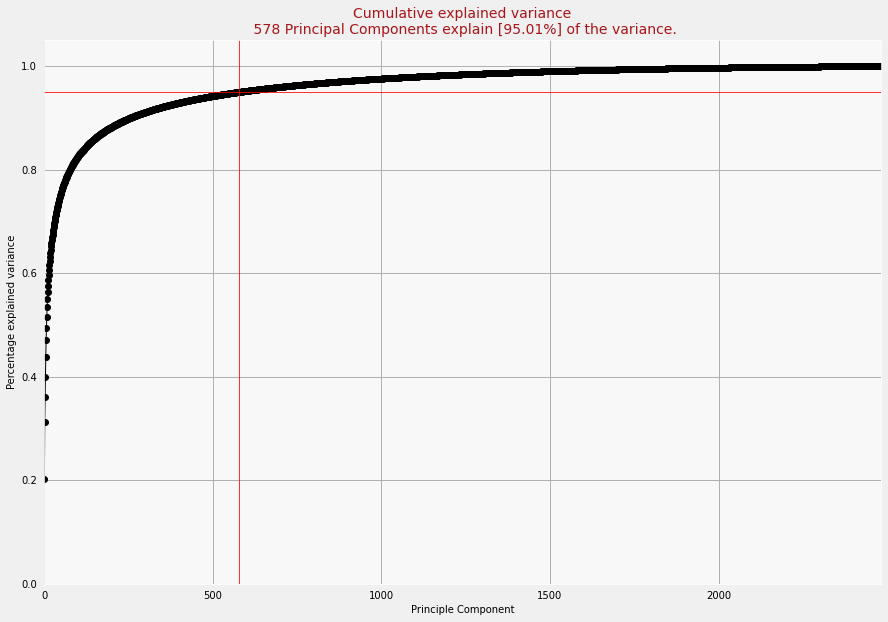

[clusteval] >Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=291337.753. Be patient now..
[clusteval] >Compute cluster labels.


<Figure size 1008x648 with 0 Axes>

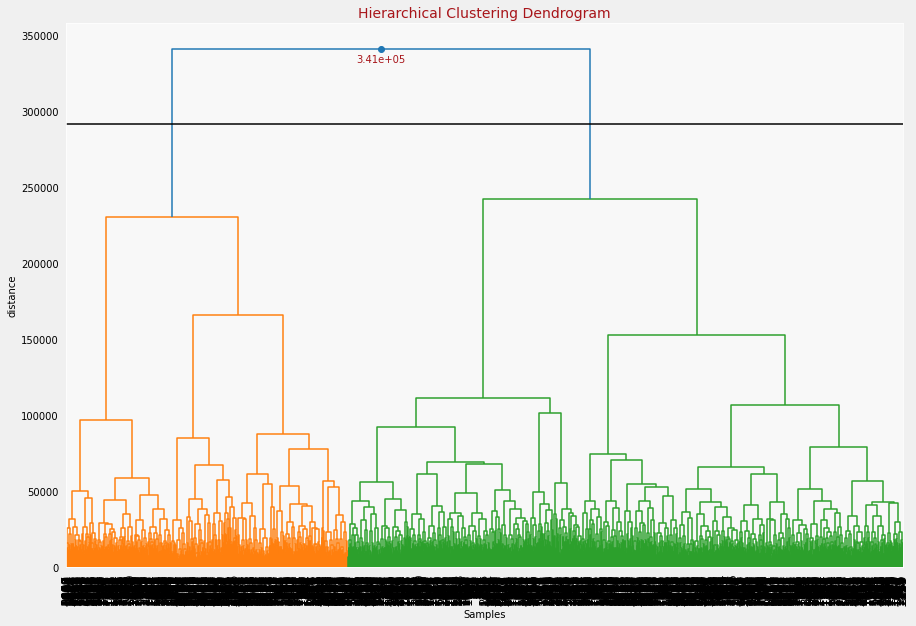

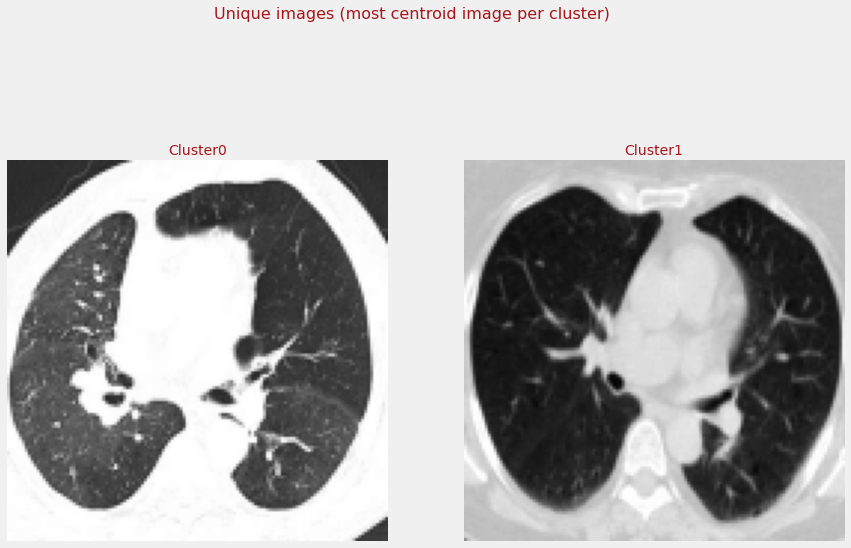

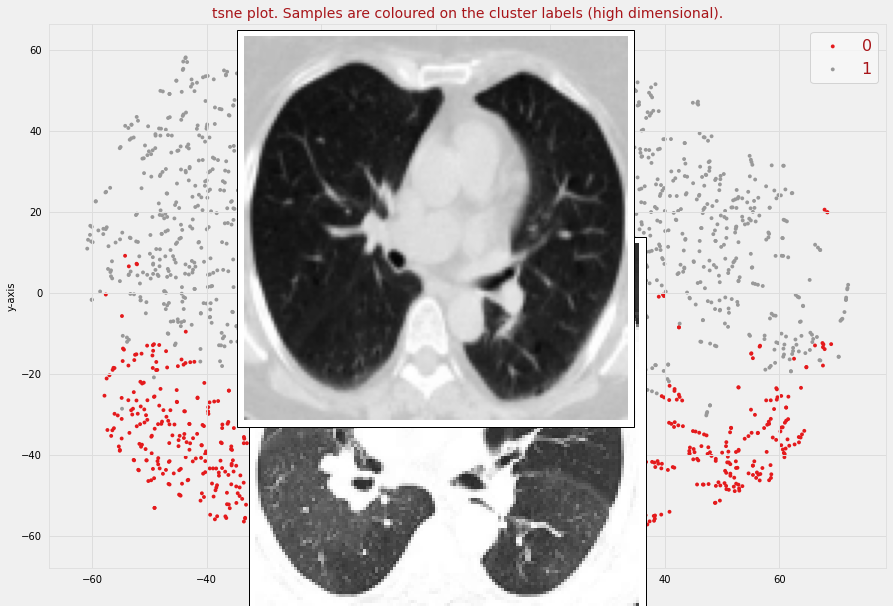

<Figure size 1008x648 with 0 Axes>

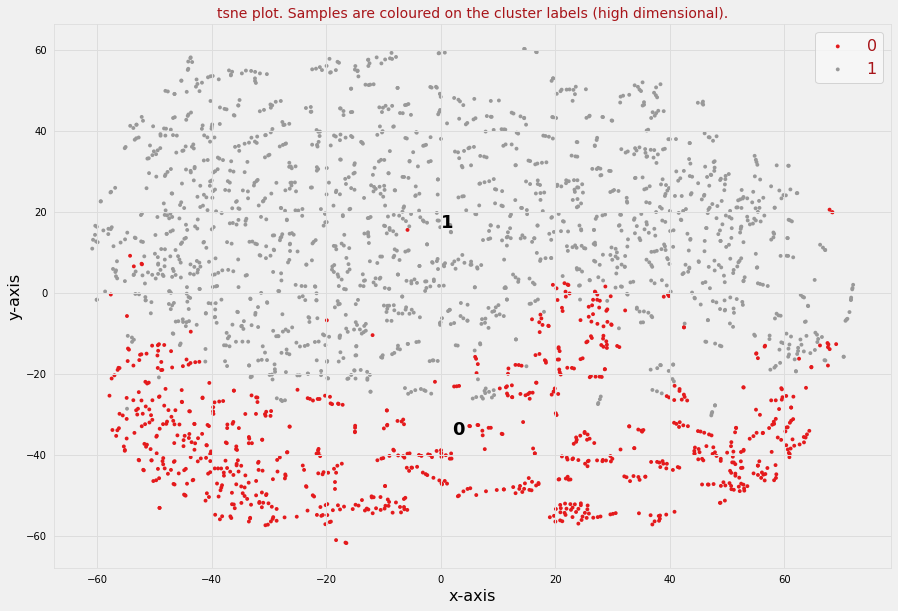

<Figure size 1008x648 with 0 Axes>

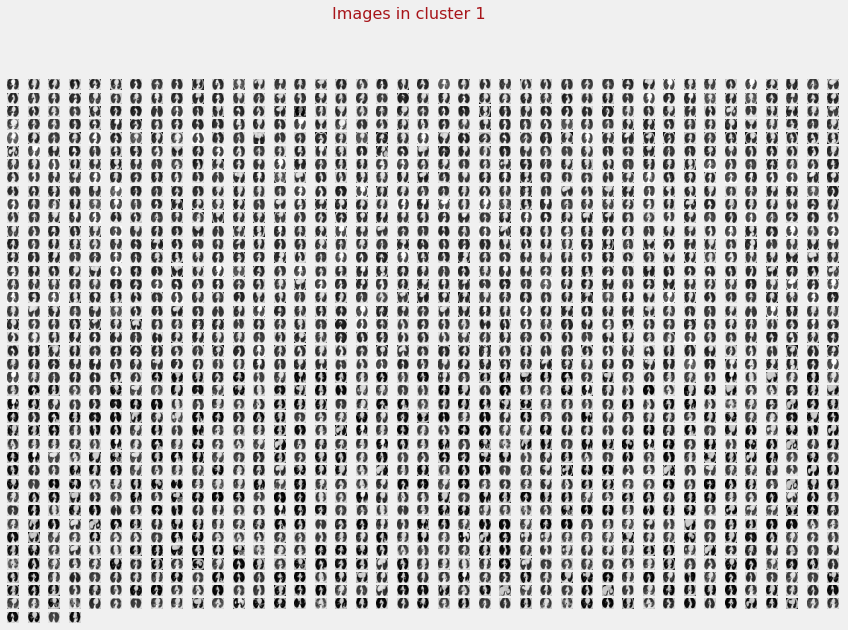

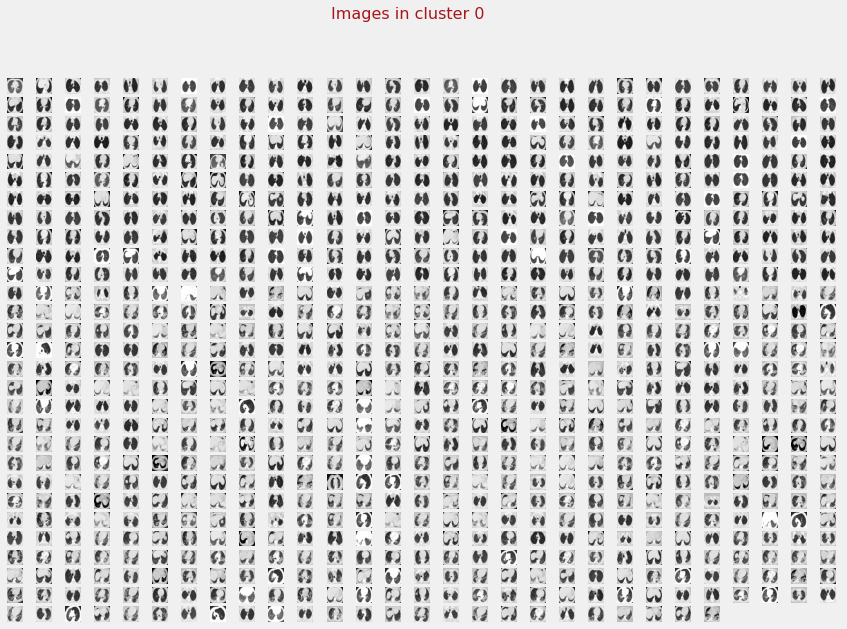

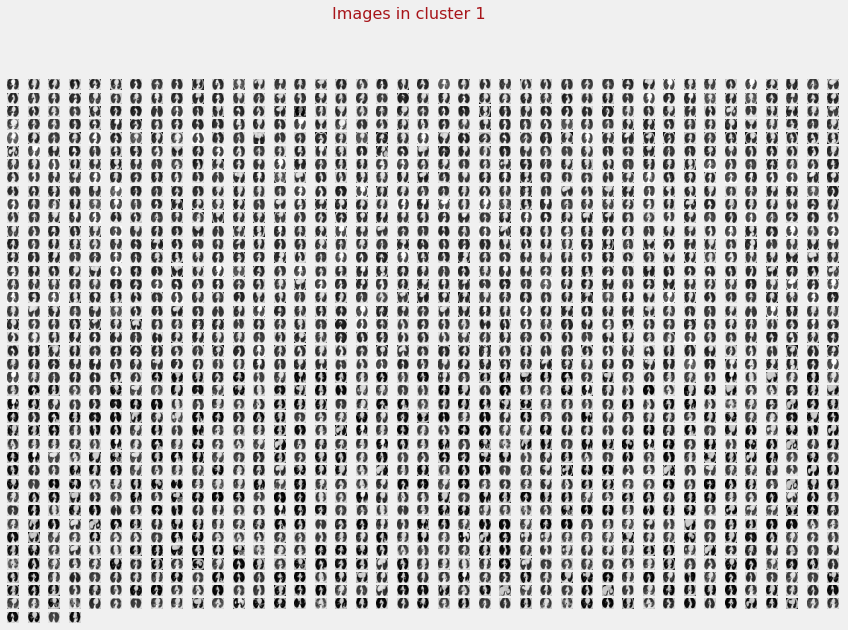

In [28]:
# Silhouette plots
cl.clusteval.plot()
cl.clusteval.scatter(cl.results['xycoord'])

# PCA explained variance plot
cl.pca.plot()

# Dendrogram
cl.dendrogram()

# Plot unique image per cluster
cl.plot_unique(img_mean=False)

# Scatterplot
cl.scatter(zoom=3, img_mean=False)
cl.scatter(zoom=None, img_mean=False)

# Plot images per cluster or all clusters
cl.plot(cmap='binary', labels=[1,2])
cl.plot(cmap='binary')

### clustering with pca method fixing 2 clusters

In [29]:
# init with PCA method
# cl = Clustimage(method='pca')
cl = Clustimage(method='pca',
                embedding='tsne',
                grayscale=False,
                dim=(128,128),
                params_pca={'n_components':0.95})

# Load data
X = cl.import_data(path_images,flatten=True)

X = X['pathnames']

print(X)

# Preprocessing, feature extraction, embedding and cluster evaluation
results = cl.fit_transform(X,
                           cluster='agglomerative',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=2,
                           cluster_space='high')
results.keys()

[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> filepath is set to [/tmp/clustimage]
[clustimage] >INFO> Extracting images from: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] files are collected recursively from path: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:23<00:00, 104.65it/s]
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.


['/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (316).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (99).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (760).png' ...
 '/content/sarscov2-ctscan-dataset/COVID/Covid (757).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (1124).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (249).png']


100%|██████████| 2481/2481 [00:18<00:00, 136.80it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [49152] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [578] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [49152] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=2481, features=578
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [pca] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


0it [00:00, ?it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (2481, 578) feature-space.


[clusteval] >No clusters detected.
[clusteval] >Optimal number clusters detected: [1].
[clusteval] >Fin.


dict_keys(['img', 'feat', 'xycoord', 'pathnames', 'labels', 'url', 'filenames'])

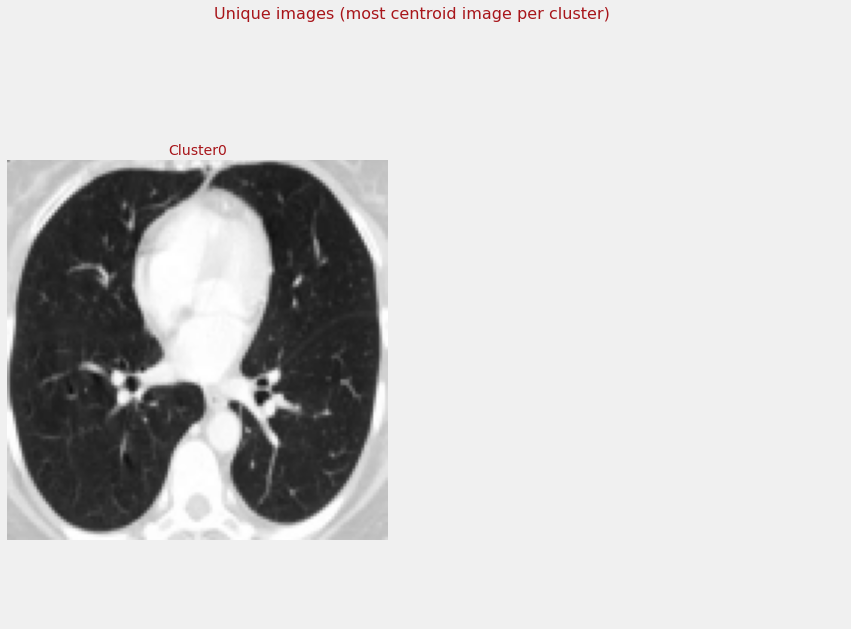

In [30]:
# Silhouette plots
#cl.clusteval.plot()
#cl.clusteval.scatter(cl.results['xycoord'])

# PCA explained variance plot
#cl.pca.plot()

# Dendrogram
#cl.dendrogram()

# Plot unique image per cluster
cl.plot_unique(img_mean=False)

# Scatterplot
#cl.scatter(zoom=3, img_mean=False)
#cl.scatter(zoom=None, img_mean=False)

# Plot images per cluster or all clusters
cl.plot(cmap='binary', labels=[1,2])
cl.plot(cmap='binary')

### clustering with hog method fixing 2 cluster

In [31]:
# init with hog method
cl = Clustimage(method='hog',
                embedding='tsne',
                grayscale=False,
                dim=(128,128),
                params_pca={'n_components':0.95})

# Load data
X = cl.import_data(path_images,flatten=True)

X = X['pathnames']

print(X)

# Preprocessing, feature extraction, embedding and cluster evaluation

results = cl.fit_transform(X,
                           cluster='agglomerative',
                           evaluate='silhouette',
                           metric='euclidean',
                           linkage='ward',
                           min_clust=2,
                           max_clust=2,
                          cluster_space='high')
results.keys()

[clustimage] >INFO> Extracting images from: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] files are collected recursively from path: [/content/sarscov2-ctscan-dataset]
[clustimage] >INFO> [2481] images are extracted.
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
100%|██████████| 2481/2481 [00:13<00:00, 189.54it/s]
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.


['/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (316).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (99).png'
 '/content/sarscov2-ctscan-dataset/non-COVID/Non-Covid (760).png' ...
 '/content/sarscov2-ctscan-dataset/COVID/Covid (757).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (1124).png'
 '/content/sarscov2-ctscan-dataset/COVID/Covid (249).png']


100%|██████████| 2481/2481 [00:12<00:00, 191.20it/s]
[clustimage] >INFO> Extracting features using method: [hog]
100%|██████████| 2481/2481 [01:49<00:00, 22.58it/s]
[clustimage] >INFO> Extracted features using [hog]: samples=2481, features=16384
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


0it [00:00, ?it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (2481, 16384) feature-space.


[clusteval] >No clusters detected.
[clusteval] >Optimal number clusters detected: [1].
[clusteval] >Fin.


dict_keys(['img', 'feat', 'xycoord', 'pathnames', 'labels', 'url', 'filenames'])

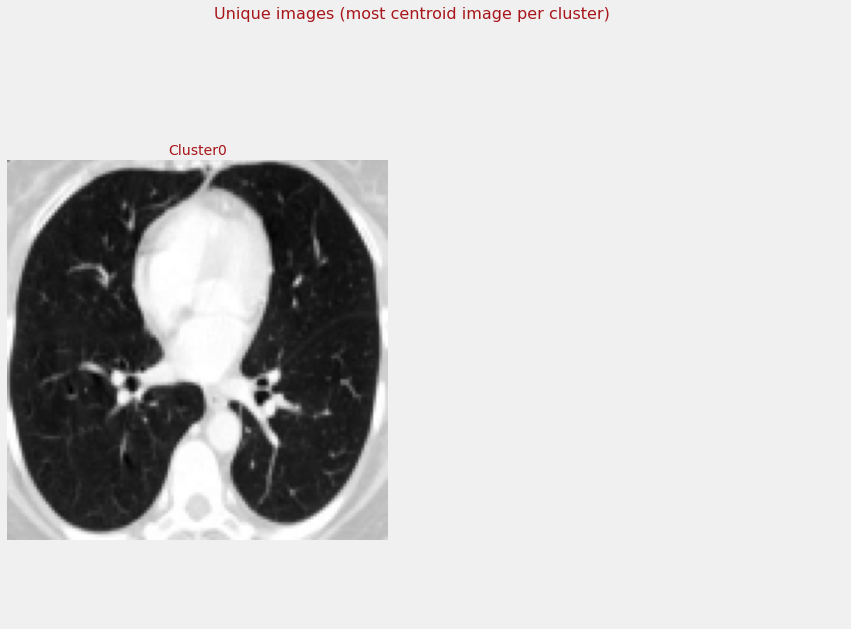

In [32]:
# Silhouette plots
#cl.clusteval.plot()
#cl.clusteval.scatter(cl.results['xycoord'])

# PCA explained variance plot
#cl.pca.plot()

# Dendrogram
#cl.dendrogram()

# Plot unique image per cluster
cl.plot_unique(img_mean=False)

# Scatterplot
#cl.scatter(zoom=3, img_mean=False)
#cl.scatter(zoom=None, img_mean=False)

# Plot images per cluster or all clusters
cl.plot(cmap='binary', labels=[1,2])
cl.plot(cmap='binary')

### clustering using VGG + TSNE + KMeans

In [33]:
# import dati
path_images = '/content/sarscov2-ctscan-dataset'

In [34]:
source_dir = '/content/sarscov2-ctscan-dataset/COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

source_dir = '/content/sarscov2-ctscan-dataset/non-COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [35]:
# change the working directory to the path where the images are located
os.chdir(path_images)

# this list holds all the image filename
img_filenames = []

# creates a ScandirIterator aliased as files
with os.scandir(path_images) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the img_filenames list
            img_filenames.append(file.name)

In [36]:
# preprocessing and loading images

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

# model
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [37]:
data = {}
p = r"/content"

# lop through each image in the dataset
for img_fn in img_filenames:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(img_fn,model)
        data[img_fn] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

In [38]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [39]:
# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(2481, 1, 4096)

In [40]:
# reshape so that there are 2481 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

(2481, 4096)

In [41]:
x_tsne = TSNE().fit_transform(feat)

In [42]:
#print(f"Components before PCA: {feat.shape[1]}")
#print(f"Components after PCA: {pca.n_components}")

In [43]:
# KMeans
kmeans = KMeans(n_clusters=2, random_state=22)
kmeans.fit(x_tsne)

KMeans(n_clusters=2, random_state=22)

In [44]:
kmeans.labels_

array([0, 1, 1, ..., 0, 1, 1], dtype=int32)

In [45]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [46]:
count = 0
for i in range(0,1000): 
  if 'Non' in groups[0][i]: 
    count += 1

print(count)

528


### Using a convolutional neural network to do feature extraction, then using kmeans algorithm

In [49]:
second_model = tf.keras.models.load_model('/content/saved_model/my_model_firstry')
second_model = Model(inputs = second_model.inputs, outputs = second_model.layers[-2].output)
second_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0   

In [50]:
# create images


source_dir = '/content/sarscov2-ctscan-dataset/COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

source_dir = '/content/sarscov2-ctscan-dataset/non-COVID'
target_dir = '/content/sarscov2-ctscan-dataset'
    
file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [51]:
path_images = '/content/sarscov2-ctscan-dataset'

In [52]:
# change the working directory to the path where the images are located
os.chdir(path_images)

# this list holds all the image filename
immagini = []

# creates a ScandirIterator aliased as files
with os.scandir(path_images) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the immagini list
            immagini.append(file.name)

In [53]:
img = load_img(immagini[0], target_size=(256, 256))
img = np.array(img)
img.shape

(256, 256, 3)

In [54]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(256,256))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(256,256,1) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [55]:
data = {}
p = r"/content/tmp"

# lop through each image in the dataset
for img_fn in immagini:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(img_fn,second_model)
        data[img_fn] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

first example of a query

extract all images that have covid-19 symptoms

# DeepLesion dataset

 Using deep lesion metadata


In [56]:
%%capture
!kaggle datasets download -d matteolimoncini/deeplesion-smallimages
!unzip deeplesion-smallimages.zip -d deeplesion-smallimages
!rm deeplesion-smallimages.zip

In [57]:
metadata = pd.read_csv('/content/sarscov2-ctscan-dataset/deeplesion-smallimages/DL_info.csv', sep = ',')
metadata.head()

,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test
0,000001_01_01_109.png,1,1,1,109,"233.537, 95.0204, 234.057, 106.977, 231.169, 1...","226.169, 90.0204, 241.252, 111.977","11.9677, 5.10387","0.44666, 0.283794, 0.434454",3,0,"103, 115","0.488281, 0.488281, 5","512, 512","-175, 275",F,62.0,3
1,000001_02_01_014.png,1,2,1,14,"224.826, 289.296, 224.016, 305.294, 222.396, 2...","217.396, 284.296, 233.978, 310.294","16.019, 6.61971","0.431015, 0.485238, 0.340745",3,0,"8, 23","0.314453, 0.314453, 5","512, 512","-175, 275",F,72.0,3
2,000001_02_01_017.png,1,2,1,17,"272.323, 320.763, 246.522, 263.371, 234.412, 3...","229.412, 258.371, 285.221, 325.763","62.9245, 48.9929","0.492691, 0.503106, 0.351754",3,0,"8, 23","0.314453, 0.314453, 5","512, 512","-175, 275",F,72.0,3
3,000001_03_01_088.png,1,3,1,88,"257.759, 157.618, 260.018, 133.524, 251.735, 1...","246.735, 128.524, 270.288, 162.618","24.1998, 13.6123","0.498999, 0.278924, 0.452792",3,0,"58, 118","0.732422, 0.732422, 1","512, 512","-175, 275",F,73.0,3
4,000001_04_01_017.png,1,4,1,17,"304.019, 230.585, 292.217, 211.789, 304.456, 2...","287.217, 206.789, 309.456, 235.585","22.1937, 9.8065","0.572678, 0.42336, 0.445674",3,0,"11, 23","0.666016, 0.666016, 5","512, 512","-175, 275",F,73.0,3


In [58]:
#@title query on csv { run: "auto" }
#inizialize 
res = metadata

#@markdown quali pazienti hanno età compresa tra x e y { run: "auto" }
età_x = 1 #@param {type:"integer"}
età_y = 30 #@param {type:"integer"}
if età_x is not None:
  res = res[(res['Patient_age'] > età_x)]
if età_y is not None:
  res = res[res['Patient_age'] < età_y]

#@markdown filtra i pazienti in base al sesso M/F { run: "auto" }
gender = "M" #@param ["M", "F", ""]
if len(gender)!=0:
  res = res[(res['Patient_gender'] == gender)]

#@markdown filtra i pazienti in base al patient index { run: "auto" }
patient_index = None #@param {type:"integer"}
if patient_index is not None:
  res = res[(res['Patient_index'] == patient_index)]

#@markdown filtra i pazienti in base allo study index { run: "auto" }
study_index = None #@param {type:"integer"}
if study_index is not None:
  res = res[(res['Study_index'] == study_index)]

#@markdown filtra i pazienti in base al filename { run: "auto" }
file_name = "" #@param {type:"string"}
if len(file_name.strip())!=0:
  res = res[(res['File_name'] == file_name.strip())]

#@markdown remove possibly noisy { run: "auto" }
remove_noisy = False #@param {type:"boolean"}
if remove_noisy:
  res = res[(res['Possibly_noisy'] == 0)]


res

,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,Possibly_noisy,Slice_range,Spacing_mm_px_,Image_size,DICOM_windows,Patient_gender,Patient_age,Train_Val_Test
22,000007_01_01_173.png,7,1,1,173,"312.964, 188.882, 312.221, 199.036, 316.927, 1...","302.763, 183.882, 321.927, 204.036","10.1816, 9.19387","0.634206, 0.394456, 0.656572",-1,0,"167, 179","0.625, 0.625, 5","512, 512","-175, 275",M,19.0,1
23,000007_02_01_073.png,7,2,1,73,"308.506, 222.119, 301.769, 221.524, 305.534, 2...","296.769, 213.751, 313.506, 228.506","6.76281, 4.77174","0.659349, 0.422289, 0.649855",-1,0,"67, 79","0.78125, 0.78125, 5","512, 512","-175, 275",M,26.0,1
24,000007_03_01_057.png,7,3,1,57,"313.432, 205.533, 293.88, 199.016, 304.742, 19...","288.88, 190.395, 318.432, 214.154","20.6098, 14.5032","0.557553, 0.398437, 0.64204",-1,0,"37, 72","0.78125, 0.78125, 2","512, 512","-175, 275",M,27.0,1
25,000007_03_01_052.png,7,3,1,52,"346.019, 259.845, 322.846, 251.879, 338.054, 2...","317.846, 241.086, 351.019, 269.914","24.5038, 19.9093","0.62647, 0.554899, 0.635449",-1,0,"37, 72","0.78125, 0.78125, 2","512, 512","-175, 275",M,27.0,1
26,000007_03_02_066.png,7,3,2,66,"217.103, 266.47, 216.152, 279.792, 222.589, 27...","206.618, 261.47, 227.589, 284.792","13.3552, 10.9984","0.357659, 0.614378, 0.609465",-1,0,"60, 72","0.78125, 0.78125, 5","512, 512","-175, 275",M,27.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32685,004441_01_01_040.png,4441,1,1,40,"245.829, 314.979, 222.964, 272.842, 242.563, 2...","212.738, 267.842, 250.829, 319.979","47.9409, 28.2443","0.458016, 0.724676, 0.542597",-1,0,"34, 46","0.945312, 0.945312, 5","512, 512","-175, 275",M,21.0,1
32686,004441_01_02_134.png,4441,1,2,134,"230.227, 242.349, 179.829, 258.704, 206.864, 2...","174.829, 225.333, 235.227, 265.372","52.9857, 31.5808","0.401414, 0.5519, 0.436979",-1,0,"104, 201","0.945312, 0.945312, 1","512, 512","-175, 275",M,21.0,1
32687,004441_01_02_171.png,4441,1,2,171,"177.971, 152.536, 199.037, 206.126, 219.734, 1...","165.209, 147.536, 224.734, 211.126","57.582, 53.2137","0.380139, 0.335162, 0.521726",-1,0,"104, 201","0.945312, 0.945312, 1","512, 512","-175, 275",M,21.0,1
32688,004441_01_02_297.png,4441,1,2,297,"173.257, 261.234, 152.628, 279.138, 155.742, 2...","147.628, 255.455, 178.257, 284.138","27.3153, 23.7076","0.31238, 0.646101, 0.638319",-1,0,"267, 327","0.945312, 0.945312, 1","512, 512","-175, 275",M,21.0,1
